1. Você deve fazer a leitura dos dados, estabelecer um índice por datas, verificar se os
dados estão corretos e realizar algum procedimento necessário caso haja dados
faltantes.

In [1]:
import os.path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [25,6]
plt.rc('font', size=14) # Altera o tamanho da fonte

%matplotlib inline

In [2]:
covid = pd.read_csv('covid19USA.csv', index_col='date', parse_dates=True)
covid.index = covid.index.to_period("D")
covid = covid.sort_values(by=['date'])

covid.head()

,confirmed,deaths
date,,
2020-01-01,0,0
2020-01-02,0,0
2020-01-03,0,0
2020-01-04,0,0
2020-01-05,0,0


- dia 20/03/20
> - está como 0 em deaths<br>
> - nos dias anteriores estão completos<br>
> - tem que ajustar esse valor <br>

INCLUIDO 1 NO DIA 20/03 E REMOVIDO 1 DO DIA 19/03



In [3]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 247 entries, 2020-01-01 to 2020-09-03
Freq: D
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   confirmed  247 non-null    int64
 1   deaths     247 non-null    int64
dtypes: int64(2)
memory usage: 5.8 KB


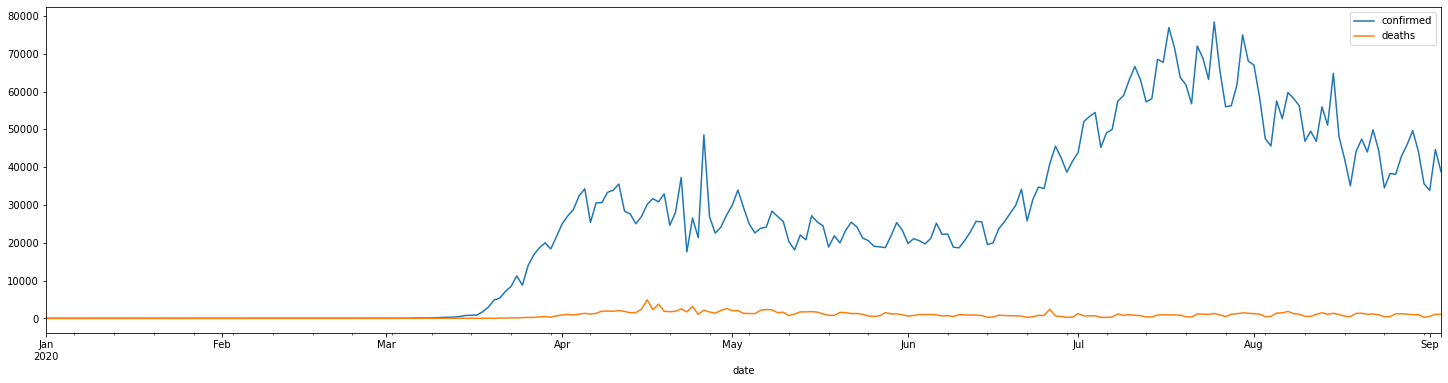

In [4]:
covid.plot(figsize=(25,6));

2. Proponha uma decomposição dos dados de mortes em tendência e sazonalidade.
Obtenha os gráficos de autocorrelação e autocorrelação parcial. Comente
brevemente os resultados.

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

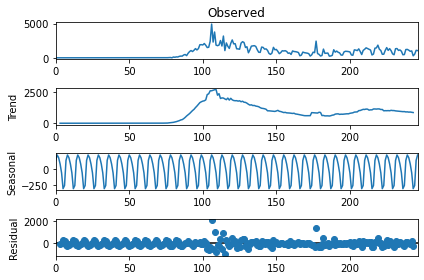

In [6]:

mortes = np.array(list(covid.deaths))

result = seasonal_decompose(mortes, model='additive', period=7)
result.plot()

plt.show()

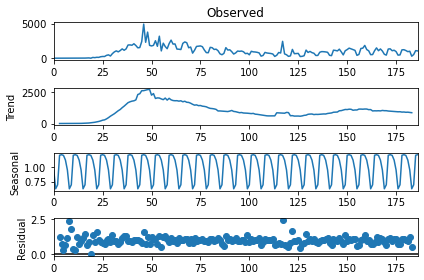

In [7]:
mortes_mult = np.array(list(covid.deaths[covid.deaths > 0]))

result = seasonal_decompose(mortes_mult, model='multiplicative', period=7)
result.plot()

plt.show()

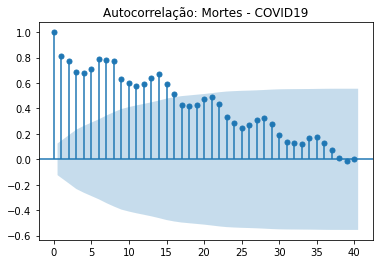

In [8]:
title = 'Autocorrelação: Mortes - COVID19'
lags = 40
plot_acf(covid.deaths, title=title,lags=lags);

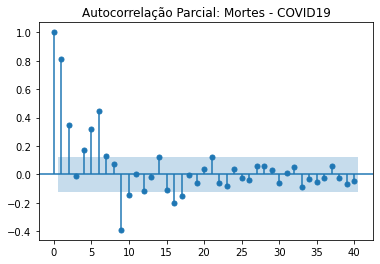

In [9]:
title = 'Autocorrelação Parcial: Mortes - COVID19'
lags = 40
plot_pacf(covid.deaths, title=title,lags=lags);

3. Divida a base em treino e teste, com 21 observações na base de teste. Você deverá
apresentar em distintas colunas na mesma base de dados que será entregue:
- Os dados originais de casos confirmados e mortes.
- As previsões de Holt e Holt Winters para a variável mortes.
- As previsões obtidas pelo melhor modelo SARIMA, com ordens selecionadas
segundo critério preestabelecido para a variável mortes. Identifique as
componentes desse melhor modelo (por exemplo, “o modelo tem uma
componente autorregressiva não sazonal de ordem .., uma componente de
médias móveis não-sazonal de ordem.., etc).
- As previsões obtidas por um modelo de redes dinâmicas para a variável
mortes.

In [10]:
treino = covid.iloc[:226]
teste = covid.iloc[226:]

In [11]:
# Método de Holt 

from statsmodels.tsa.api import ExponentialSmoothing

modelo =  ExponentialSmoothing(treino.deaths, trend='add');

ajustado = modelo.fit();

treino['Holt'] = ajustado.fittedvalues.shift(-1);

treino.head()

,confirmed,deaths,Holt
date,,,
2020-01-01,0,0,8.392380
2020-01-02,0,0,10.750519
2020-01-03,0,0,12.376750
2020-01-04,0,0,13.498238
2020-01-05,0,0,14.271644


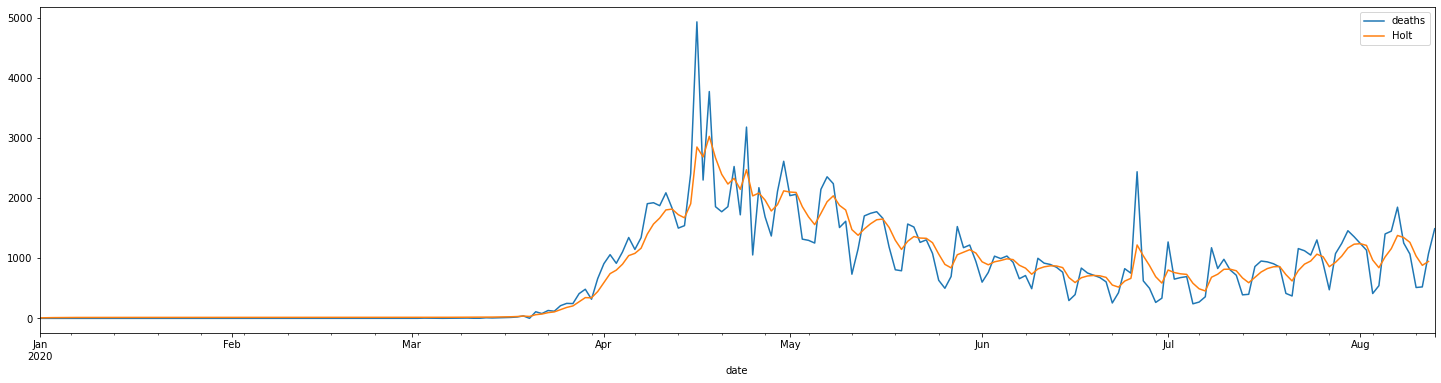

In [12]:
treino[['deaths','Holt']].plot(figsize=(25,6)).autoscale(axis='x',tight=True);

In [13]:
# Ajuste do modelo pelo Método de Holt-Winters com sazonalidade aditiva

modelo =  ExponentialSmoothing(treino.deaths,trend='add',seasonal='add',seasonal_periods=7);

ajustado = modelo.fit();

treino['Holt-Winters-adit-7'] = ajustado.fittedvalues;

treino.head()

,confirmed,deaths,Holt,Holt-Winters-adit-7
date,,,,
2020-01-01,0,0,8.392380,42.833535
2020-01-02,0,0,10.750519,34.679682
2020-01-03,0,0,12.376750,-38.995762
2020-01-04,0,0,13.498238,-47.338177
2020-01-05,0,0,14.271644,-61.734098


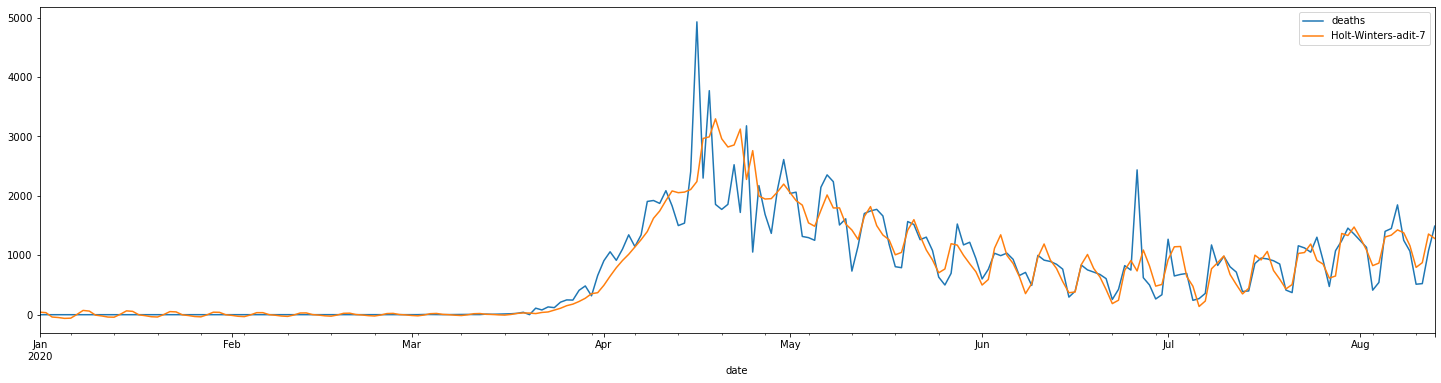

In [14]:
treino[['deaths','Holt-Winters-adit-7']].plot(figsize=(25,6)).autoscale(axis='x',tight=True);

In [15]:
treino_mult = covid.iloc[:226]
teste_mult = covid.iloc[226:]

treino_mult = treino_mult[treino_mult.deaths > 0]
teste_mult = teste_mult[teste_mult.deaths > 0]

In [16]:
# Ajuste do modelo pelo Método de Holt-Winters com sazonalidade multiplicativa


modelo =  ExponentialSmoothing(treino_mult.deaths,trend='add',seasonal='mul',seasonal_periods=7)

ajustado = modelo.fit()

treino_mult['Holt-Winters-mult-7'] = ajustado.fittedvalues

treino_mult.head()

,confirmed,deaths,Holt-Winters-mult-7
date,,,
2020-03-01,3,1,0.003166
2020-03-02,20,1,230.965286
2020-03-03,14,4,158.064812
2020-03-04,22,3,164.927868
2020-03-05,34,2,148.058263


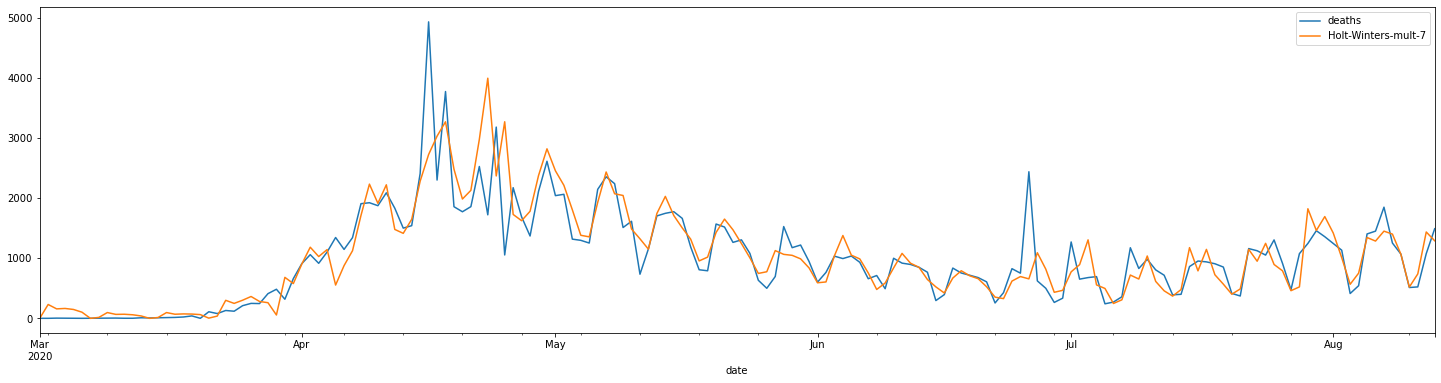

In [17]:
treino_mult[['deaths','Holt-Winters-mult-7']].plot(figsize=(25,6)).autoscale(axis='x',tight=True);

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima                              

# Ignorar warnings não prejudiciais
import warnings
warnings.filterwarnings("ignore")

In [ ]:

auto_arima(covid.deaths,seasonal=True,m=7).summary()

stepwise_fit = auto_arima(covid.deaths, start_p=0, start_q=0,
                          max_p=6, max_q=3, m=7,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)           

stepwise_fit.summary()